In [1]:
import dill
from dev.constants import gdrive_path

import torch as t
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA

cmap = {
    0.: "red",
    0.5: "green",
    1.: "blue"
}

pca_legend_elements = [
    mpatches.Patch(facecolor="blue", label="Claim 1"),
    mpatches.Patch(facecolor="green", label="Neither"),
    mpatches.Patch(facecolor="red", label="Claim 2")
]

device = t.device("cpu")

In [2]:
# load activations and labels
_x1, _x2, labels = [], [], []
for report in ["AR3", "AR4", "AR5", "AR6"]:
    x1 = t.load(f"{gdrive_path}/climatex/activations/{report}_1.pt", pickle_module=dill, map_location=device)
    x2 = t.load(f"{gdrive_path}/climatex/activations/{report}_2.pt", pickle_module=dill, map_location=device)
    prompts = pd.read_json(f"{gdrive_path}/climatex/prompts/{report}.jsonl", orient="records", lines=True)
    _x1.append(x1); _x2.append(x2); labels.append(prompts)
x1 = t.concat(_x1); x2 = t.concat(_x2)
labels = pd.concat(labels).reset_index(drop=True)
# center x1 and x2 to remove syntactical contrastive feature
x1, x2 = x1 - x1.mean(dim=0), x2 - x2.mean(dim=0)
# store data and labels
x = x1-x2
y = t.from_numpy(labels["true"].to_numpy()).to(device)

In [3]:
pca = PCA(n_components=3)
# small subset of x
perm = t.randperm(len(x))
_x = x[perm[:10_000]]
_y = y[perm[:10_000]]
clrs = [cmap[p.item()] for p in _y]
X = pca.fit_transform(_x)

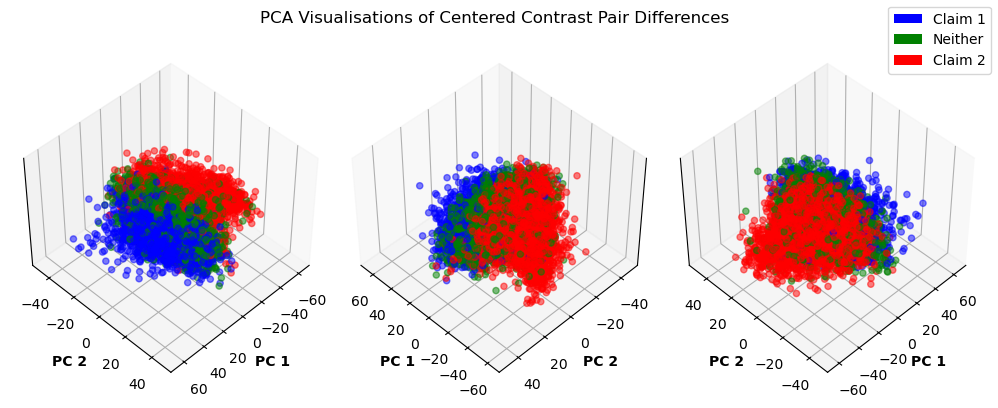

In [17]:
fig = plt.figure(figsize=(10, 4))

for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection="3d")
    ax.view_init(elev=45, azim=45+(i*90))
    ax.set_box_aspect(None, zoom=1)
    ax.set_zticks([])
    ax.set_xlabel("PC 1", weight="bold")
    ax.set_ylabel("PC 2", weight="bold")
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.5, c=clrs)

plt.suptitle("PCA Visualisations of Centered Contrast Pair Differences")
plt.figlegend(handles=pca_legend_elements)
plt.tight_layout()
plt.savefig(f"{gdrive_path}/climatex/pca.png", dpi=400)
plt.show()